# 实验七：中国股市条件波动率模型的估计与检验

## 一、文献学习
1. 认真阅读三篇文献资料，了解波动率模型的相关研究，重点关注其中的建模思路、参数估计方法和应用场景。

## 二、实验数据
- 时间范围：2000/01 - 2020/12
- 数据来源：
  - 上证综指
  - 深圳成指
  - 自选个股 2 只

## 三、实验内容（参考课本《金融计量学》P131 - 135 页）

### （一）描述性统计
- 对指数和个股收益率及其绝对值进行描述性统计，计算以下指标：
  - 交易日天数
  - 均值
  - 标准差
  - 偏度
  - 峰度
  - 最大值
  - 最小值
  - 自相关系数

### （二）ARCH 效应检验
- 检验指数和个股收益率是否具有 ARCH 效应。

### （三）ARCH(1) 模型和 GARCH(1, 1) 模型估计
- 利用指数和个股收益率数据估计 ARCH(1) 模型和 GARCH(1, 1) 模型。
- 判断这两个模型能否刻画收益率的条件异方差特性。

### （四）EGARCH(1, 1) 模型估计
- 利用指数和个股收益率数据估计 EGARCH(1, 1) 模型。
- 判断指数和个股收益率是否具有杠杆效应。
- 检验 EGARCH(1, 1) 模型能否刻画收益率的条件异方差特性。

### （五）模拟与对比
- 利用估计参数，分别对运用 ARCH(1) 模型、GARCH(1, 1) 模型、EGARCH(1, 1) 模型对指数和个股收益率进行模拟（模拟序列长度和原始收益率序列长度一致）。
- 将模拟序列与原始收益率序列画在同一幅图上进行对比。

In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  

# 设置随机数种子，确保结果可复现
"""
在这个实验中，我们使用 ARCH、GARCH 和 EGARCH 模型进行模拟时，会用到随机数生成器来模拟残差项（通常是从正态分布中抽取的随机数）。如果不设置随机种子，每次运行代码时生成的随机数序列都会不同，导致：

模拟结果每次都不一样，无法复现
难以比较不同模型之间的模拟效果，因为随机性的差异可能会掩盖模型本身的差异
实验结果无法被他人验证
"""
np.random.seed(42)

ts.set_token('2207b01a244311f7742512463d9e1588954d174b86d695f8a9f1cc4b')
pro = ts.pro_api()

In [2]:
# 定义数据获取函数
def get_stock_data(code, start_date='20000101', end_date='20201231'):
    """
    获取股票数据
    code: 股票代码，如'000001.SZ'
    """
    if code in ['000001.SH', '399001.SZ']:  # 上证指数或深证成指
        df = pro.index_daily(ts_code=code, start_date=start_date, end_date=end_date)
    else:  # 个股
        df = pro.daily(ts_code=code, start_date=start_date, end_date=end_date)
    
    # 按日期升序排列
    df = df.sort_values('trade_date')
    
    # 重置索引
    df = df.reset_index(drop=True)
    
    # 仅保留日期和收盘价
    df = df[['trade_date', 'close']]
    
    return df

In [3]:
# 获取上证指数数据
sh_index = get_stock_data('000001.SH')
sh_index.columns = ['date', 'close']

# 获取深证成指数据
sz_index = get_stock_data('399001.SZ')
sz_index.columns = ['date', 'close']

# 获取两只个股数据 - 贵州茅台和平安银行
stock1 = get_stock_data('600519.SH')  # 贵州茅台
stock1.columns = ['date', 'close']

stock2 = get_stock_data('000001.SZ')  # 平安银行
stock2.columns = ['date', 'close']

In [4]:
# 计算对数收益率
def calculate_returns(df):
    """计算对数收益率"""
    p = df.loc[:, ['close']].values
    # 使用numpy的log和diff函数计算对数收益率
    r = np.diff(np.log(p), axis=0)
    # 创建新的DataFrame保存收益率
    returns_df = pd.DataFrame({
        'date': df['date'].values[1:],
        'returns': r.flatten()
    })
    return returns_df

# 计算各个指数和股票的收益率
sh_returns = calculate_returns(sh_index)
sz_returns = calculate_returns(sz_index)
stock1_returns = calculate_returns(stock1)
stock2_returns = calculate_returns(stock2)

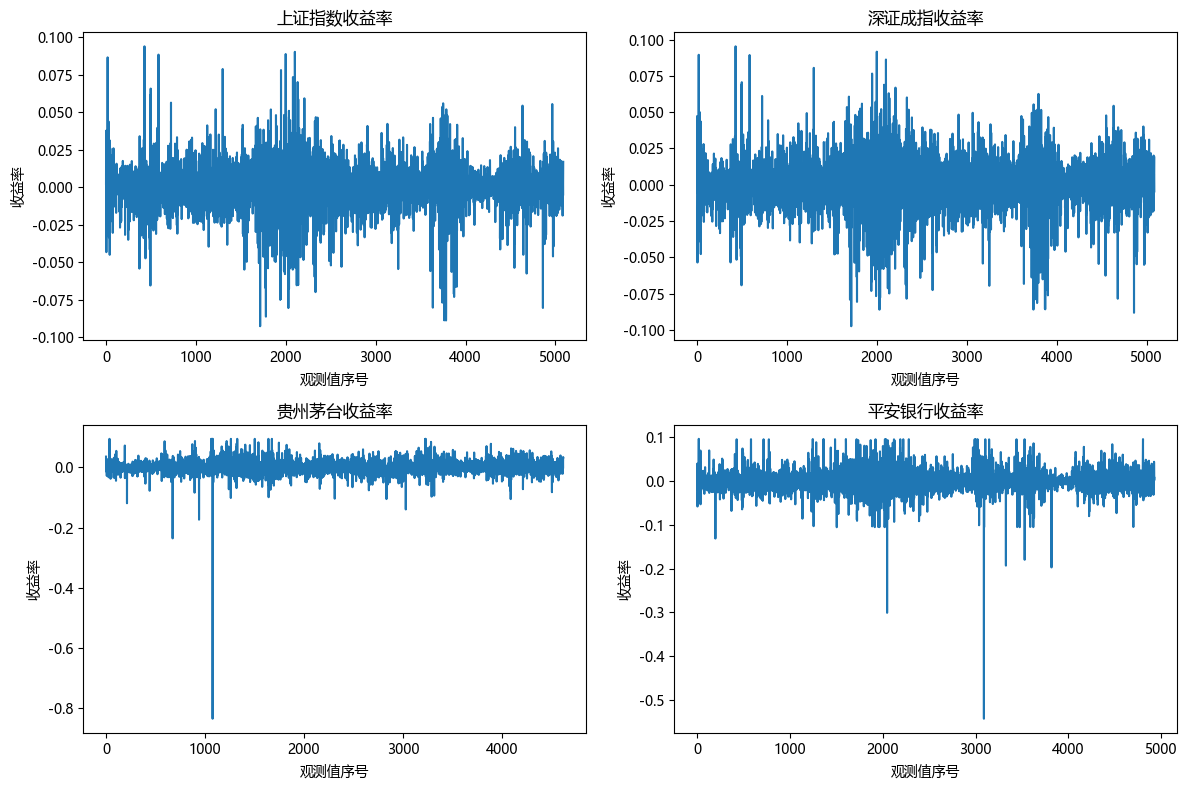

In [5]:
# 可视化收益率时间序列
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(sh_returns['returns'])
plt.title('上证指数收益率')
plt.xlabel('观测值序号')
plt.ylabel('收益率')

plt.subplot(2, 2, 2)
plt.plot(sz_returns['returns'])
plt.title('深证成指收益率')
plt.xlabel('观测值序号')
plt.ylabel('收益率')

plt.subplot(2, 2, 3)
plt.plot(stock1_returns['returns'])
plt.title('贵州茅台收益率')
plt.xlabel('观测值序号')
plt.ylabel('收益率')

plt.subplot(2, 2, 4)
plt.plot(stock2_returns['returns'])
plt.title('平安银行收益率')
plt.xlabel('观测值序号')
plt.ylabel('收益率')

plt.tight_layout()
plt.show()

In [6]:
def descriptive_stats(returns_series, name):
    """计算描述性统计量"""
    # 收益率的描述性统计
    stats_df = pd.DataFrame({
        '指标': ['交易日天数', '均值', '标准差', '偏度', '峰度', '最大值', '最小值'],
        f'{name}收益率': [
            len(returns_series),
            returns_series.mean(),
            returns_series.std(),
            stats.skew(returns_series),
            stats.kurtosis(returns_series),  # 这是超额峰度，比正态分布的峰度多出的部分
            returns_series.max(),
            returns_series.min()
        ],
        f'{name}收益率绝对值': [
            len(returns_series),
            np.abs(returns_series).mean(),
            np.abs(returns_series).std(),
            stats.skew(np.abs(returns_series)),
            stats.kurtosis(np.abs(returns_series)),
            np.abs(returns_series).max(),
            np.abs(returns_series).min()
        ]
    })
    
    # 计算自相关系数（滞后1阶）
    acf_returns = np.corrcoef(returns_series[:-1], returns_series[1:])[0, 1]
    acf_abs_returns = np.corrcoef(np.abs(returns_series)[:-1], np.abs(returns_series)[1:])[0, 1]
    
    # 添加自相关系数行
    stats_df = stats_df._append({
        '指标': '自相关系数(滞后1阶)',
        f'{name}收益率': acf_returns,
        f'{name}收益率绝对值': acf_abs_returns
    }, ignore_index=True)
    
    return stats_df

# 计算各个指数和股票的描述性统计量
sh_stats = descriptive_stats(sh_returns['returns'], '上证指数')
sz_stats = descriptive_stats(sz_returns['returns'], '深证成指')
stock1_stats = descriptive_stats(stock1_returns['returns'], '贵州茅台')
stock2_stats = descriptive_stats(stock2_returns['returns'], '平安银行')

# 展示描述性统计结果
print("上证指数描述性统计：")
print(sh_stats)
print("\n深证成指描述性统计：")
print(sz_stats)
print("\n贵州茅台描述性统计：")
print(stock1_stats)
print("\n平安银行描述性统计：")
print(stock2_stats)

上证指数描述性统计：
            指标      上证指数收益率   上证指数收益率绝对值
0        交易日天数  5088.000000  5088.000000
1           均值     0.000178     0.010558
2          标准差     0.015485     0.011329
3           偏度    -0.370718     2.522152
4           峰度     5.008859     9.533885
5          最大值     0.094010     0.094010
6          最小值    -0.092561     0.000001
7  自相关系数(滞后1阶)     0.022134     0.178830

深证成指描述性统计：
            指标      深证成指收益率   深证成指收益率绝对值
0        交易日天数  5088.000000  5088.000000
1           均值     0.000279     0.012350
2          标准差     0.017565     0.012491
3           偏度    -0.359728     2.225669
4           峰度     3.585536     7.036860
5          最大值     0.095299     0.097501
6          最小值    -0.097501     0.000005
7  自相关系数(滞后1阶)     0.044946     0.163643

贵州茅台描述性统计：
            指标      贵州茅台收益率   贵州茅台收益率绝对值
0        交易日天数  4621.000000  4621.000000
1           均值     0.000872     0.015105
2          标准差     0.024618     0.019457
3           偏度    -8.653293    17.681488
4           峰度   293.0

In [7]:
def arch_effect_test(returns, name):
    """
    进行ARCH效应检验
    returns: 收益率序列
    name: 数据名称
    """
    # 滞后阶数设为10
    lags = 10
    result = het_arch(returns, nlags=lags)
    
    # 检验结果
    lm_stat = result[0]
    lm_p_value = result[1]
    f_stat = result[2]
    f_p_value = result[3]
    
    # 输出检验结果
    print(f"{name} ARCH效应检验结果：")
    print(f"LM统计量：{lm_stat:.4f}，p值：{lm_p_value:.10f}")
    print(f"F统计量：{f_stat:.4f}，p值：{f_p_value:.10f}")
    
    # 判断是否存在ARCH效应
    if lm_p_value < 0.05:
        print(f"{name} 存在ARCH效应")
        return True
    else:
        print(f"{name} 不存在ARCH效应")
        return False

# 对各个收益率序列进行ARCH效应检验
print("ARCH效应检验：")
sh_arch = arch_effect_test(sh_returns['returns'], '上证指数')
sz_arch = arch_effect_test(sz_returns['returns'], '深证成指')
stock1_arch = arch_effect_test(stock1_returns['returns'], '贵州茅台')
stock2_arch = arch_effect_test(stock2_returns['returns'], '平安银行')

ARCH效应检验：
上证指数 ARCH效应检验结果：
LM统计量：459.6662，p值：0.0000000000
F统计量：50.4322，p值：0.0000000000
上证指数 存在ARCH效应
深证成指 ARCH效应检验结果：
LM统计量：464.8532，p值：0.0000000000
F统计量：51.0587，p值：0.0000000000
深证成指 存在ARCH效应
贵州茅台 ARCH效应检验结果：
LM统计量：4.8683，p值：0.8998031865
F统计量：0.4862，p值：0.9001122680
贵州茅台 不存在ARCH效应
平安银行 ARCH效应检验结果：
LM统计量：14.6670，p值：0.1446809567
F统计量：1.4678，p值：0.1446415245
平安银行 不存在ARCH效应


In [8]:
def estimate_arch_garch_models(returns, name):
    """
    估计ARCH(1)和GARCH(1,1)模型
    returns: 收益率序列
    name: 数据名称
    """
    print(f"\n{name} 的 ARCH(1) 和 GARCH(1,1) 模型估计：")
    
    # 估计ARCH(1)模型
    arch1_model = arch_model(returns*100, mean='constant', vol='ARCH', p=1, dist='normal')
    arch1_result = arch1_model.fit(disp='off')
    print("\nARCH(1) 模型估计结果：")
    print(arch1_result.summary())
    
    # 估计GARCH(1,1)模型
    garch11_model = arch_model(returns*100, mean='constant', vol='GARCH', p=1, q=1, dist='normal')
    garch11_result = garch11_model.fit(disp='off')
    print("\nGARCH(1,1) 模型估计结果：")
    print(garch11_result.summary())
    
    # 对标准化残差进行ARCH效应检验
    std_resid_arch1 = arch1_result.resid / arch1_result.conditional_volatility
    std_resid_garch11 = garch11_result.resid / garch11_result.conditional_volatility
    
    print("\nARCH(1)模型标准化残差的ARCH效应检验：")
    arch_effect_test(std_resid_arch1, f"{name} ARCH(1)模型标准化残差")
    
    print("\nGARCH(1,1)模型标准化残差的ARCH效应检验：")
    arch_effect_test(std_resid_garch11, f"{name} GARCH(1,1)模型标准化残差")
    
    return arch1_result, garch11_result

# 对各个收益率序列估计ARCH(1)和GARCH(1,1)模型
sh_arch1, sh_garch11 = estimate_arch_garch_models(sh_returns['returns'], '上证指数')
sz_arch1, sz_garch11 = estimate_arch_garch_models(sz_returns['returns'], '深证成指')
stock1_arch1, stock1_garch11 = estimate_arch_garch_models(stock1_returns['returns'], '贵州茅台')
stock2_arch1, stock2_garch11 = estimate_arch_garch_models(stock2_returns['returns'], '平安银行')


上证指数 的 ARCH(1) 和 GARCH(1,1) 模型估计：

ARCH(1) 模型估计结果：
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9287.14
Distribution:                  Normal   AIC:                           18580.3
Method:            Maximum Likelihood   BIC:                           18599.9
                                        No. Observations:                 5088
Date:                Thu, Apr 17 2025   Df Residuals:                     5087
Time:                        16:41:00   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu 

In [9]:
def estimate_egarch_model(returns, name):
    """
    估计EGARCH(1,1)模型
    returns: 收益率序列
    name: 数据名称
    """
    print(f"\n{name} 的 EGARCH(1,1) 模型估计：")
    
    # 估计EGARCH(1,1)模型
    egarch11_model = arch_model(returns*100, mean='constant', vol='EGARCH', p=1, q=1, o=1, dist='normal')
    egarch11_result = egarch11_model.fit(disp='off')
    print("\nEGARCH(1,1) 模型估计结果：")
    print(egarch11_result.summary())
    
    # 判断是否存在杠杆效应
    gamma = egarch11_result.params['gamma[1]']
    gamma_std_err = egarch11_result.std_err['gamma[1]']
    t_stat = gamma / gamma_std_err
    
    # 使用正态分布近似计算p值
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    print(f"\n杠杆效应检验：")
    print(f"gamma[1] = {gamma:.6f}, 标准误 = {gamma_std_err:.6f}")
    print(f"t统计量 = {t_stat:.6f}, p值 = {p_value:.6f}")
    
    if p_value < 0.05 and gamma < 0:
        print(f"{name} 存在显著的杠杆效应")
    else:
        print(f"{name} 不存在显著的杠杆效应")
    
    # 对标准化残差进行ARCH效应检验
    std_resid_egarch11 = egarch11_result.resid / egarch11_result.conditional_volatility
    
    print("\nEGARCH(1,1)模型标准化残差的ARCH效应检验：")
    arch_effect_test(std_resid_egarch11, f"{name} EGARCH(1,1)模型标准化残差")
    
    return egarch11_result

# 对各个收益率序列估计EGARCH(1,1)模型
sh_egarch11 = estimate_egarch_model(sh_returns['returns'], '上证指数')
sz_egarch11 = estimate_egarch_model(sz_returns['returns'], '深证成指')
stock1_egarch11 = estimate_egarch_model(stock1_returns['returns'], '贵州茅台')
stock2_egarch11 = estimate_egarch_model(stock2_returns['returns'], '平安银行')


上证指数 的 EGARCH(1,1) 模型估计：

EGARCH(1,1) 模型估计结果：
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -8686.26
Distribution:                  Normal   AIC:                           17382.5
Method:            Maximum Likelihood   BIC:                           17415.2
                                        No. Observations:                 5088
Date:                Thu, Apr 17 2025   Df Residuals:                     5087
Time:                        16:41:00   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu      

In [10]:
def simulate_and_compare(returns, arch1_result, garch11_result, egarch11_result, name):
    """
    使用估计的模型参数进行模拟，并与原始收益率序列进行对比
    """
    # 获取序列长度
    n = len(returns)
    
    # 进行ARCH(1)模型模拟
    arch1_sim = arch_model(None, mean='constant', vol='ARCH', p=1, dist='normal')
    arch1_params = arch1_result.params
    arch1_sim_data = arch1_sim.simulate(arch1_params, n)

    if hasattr(arch1_sim_data, 'data'):
        arch1_sim_returns = arch1_sim_data.data / 100  # 转回原始尺度
    else:
        # 对于DataFrame格式的结果，取第一列
        arch1_sim_returns = arch1_sim_data.iloc[:, 0] / 100
    
    # 进行GARCH(1,1)模型模拟
    garch11_sim = arch_model(None, mean='constant', vol='GARCH', p=1, q=1, dist='normal')
    garch11_params = garch11_result.params
    garch11_sim_data = garch11_sim.simulate(garch11_params, n)

    if hasattr(garch11_sim_data, 'data'):
        garch11_sim_returns = garch11_sim_data.data / 100
    else:
        garch11_sim_returns = garch11_sim_data.iloc[:, 0] / 100
    
    # 进行EGARCH(1,1)模型模拟
    egarch11_sim = arch_model(None, mean='constant', vol='EGARCH', p=1, q=1, o=1, dist='normal')
    egarch11_params = egarch11_result.params
    egarch11_sim_data = egarch11_sim.simulate(egarch11_params, n)

    if hasattr(egarch11_sim_data, 'data'):
        egarch11_sim_returns = egarch11_sim_data.data / 100
    else:
        egarch11_sim_returns = egarch11_sim_data.iloc[:, 0] / 100
    
    # 绘制对比图
    plt.figure(figsize=(12, 10))
    
    # 绘制原始收益率与ARCH(1)模拟收益率对比
    plt.subplot(3, 1, 1)
    plt.plot(returns, label='原始收益率', alpha=0.7)
    plt.plot(arch1_sim_returns, label='ARCH(1)模拟收益率', alpha=0.7)
    plt.title(f'{name} 原始收益率与ARCH(1)模拟收益率对比')
    plt.legend()
    plt.xlabel('观测值序号')
    plt.ylabel('收益率')
    
    # 绘制原始收益率与GARCH(1,1)模拟收益率对比
    plt.subplot(3, 1, 2)
    plt.plot(returns, label='原始收益率', alpha=0.7)
    plt.plot(garch11_sim_returns, label='GARCH(1,1)模拟收益率', alpha=0.7)
    plt.title(f'{name} 原始收益率与GARCH(1,1)模拟收益率对比')
    plt.legend()
    plt.xlabel('观测值序号')
    plt.ylabel('收益率')
    
    # 绘制原始收益率与EGARCH(1,1)模拟收益率对比
    plt.subplot(3, 1, 3)
    plt.plot(returns, label='原始收益率', alpha=0.7)
    plt.plot(egarch11_sim_returns, label='EGARCH(1,1)模拟收益率', alpha=0.7)
    plt.title(f'{name} 原始收益率与EGARCH(1,1)模拟收益率对比')
    plt.legend()
    plt.xlabel('观测值序号')
    plt.ylabel('收益率')
    
    plt.tight_layout()
    plt.show()
    
    # 返回模拟结果，以便进一步分析
    return arch1_sim_returns, garch11_sim_returns, egarch11_sim_returns

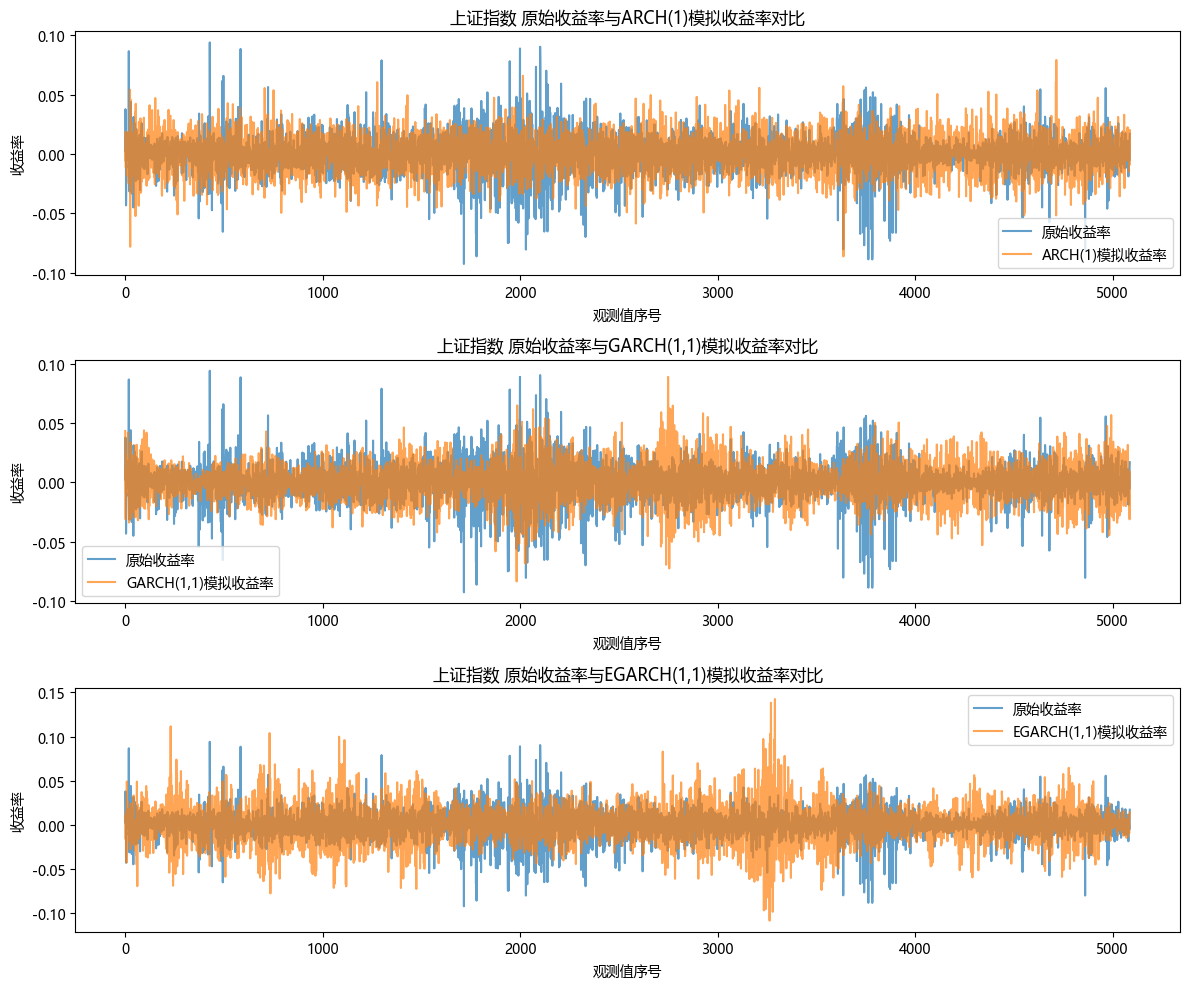

In [11]:
sh_sim_arch1, sh_sim_garch11, sh_sim_egarch11 = simulate_and_compare(
    sh_returns['returns'], sh_arch1, sh_garch11, sh_egarch11, '上证指数')

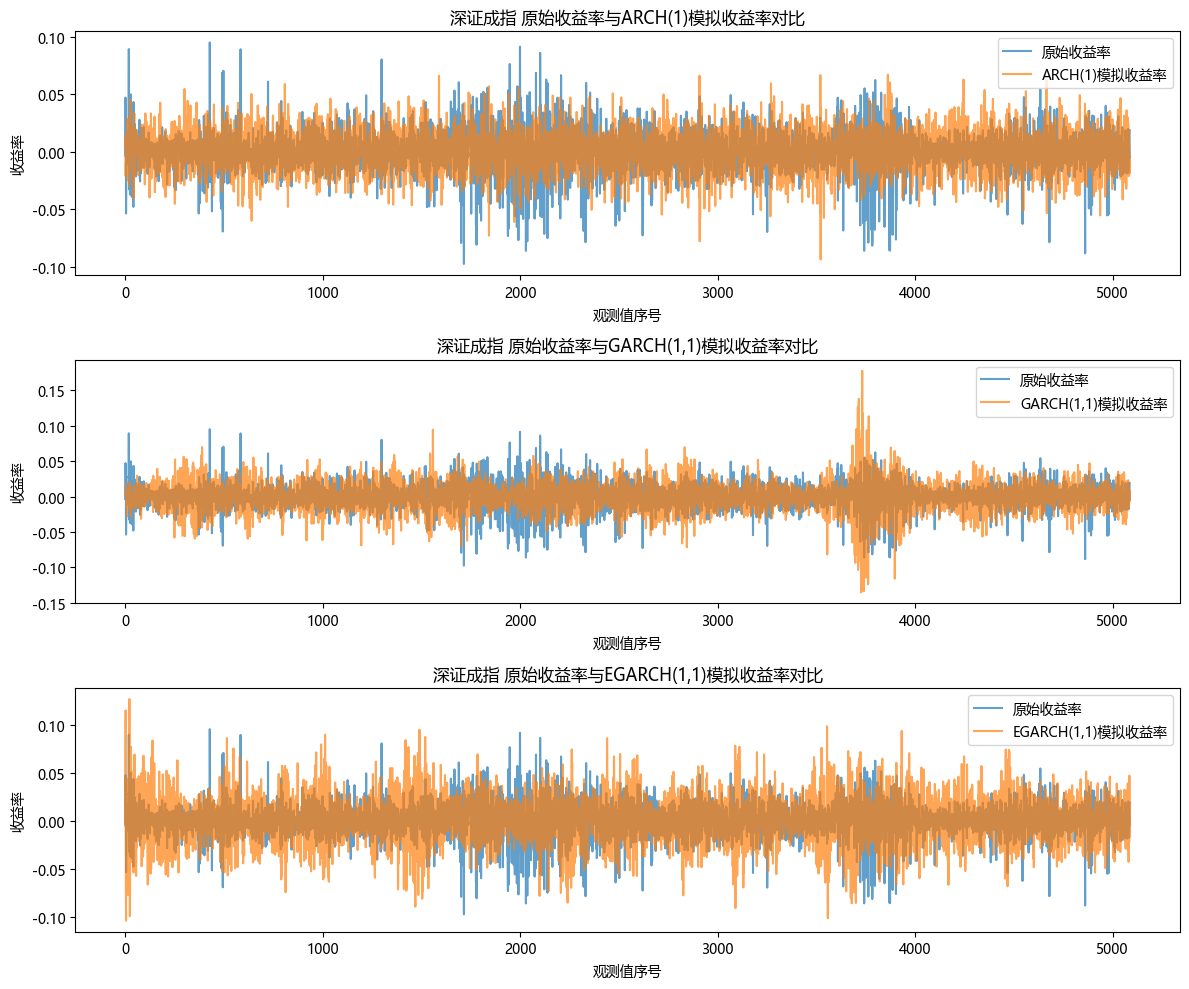

In [12]:
sz_sim_arch1, sz_sim_garch11, sz_sim_egarch11 = simulate_and_compare(
    sz_returns['returns'], sz_arch1, sz_garch11, sz_egarch11, '深证成指')

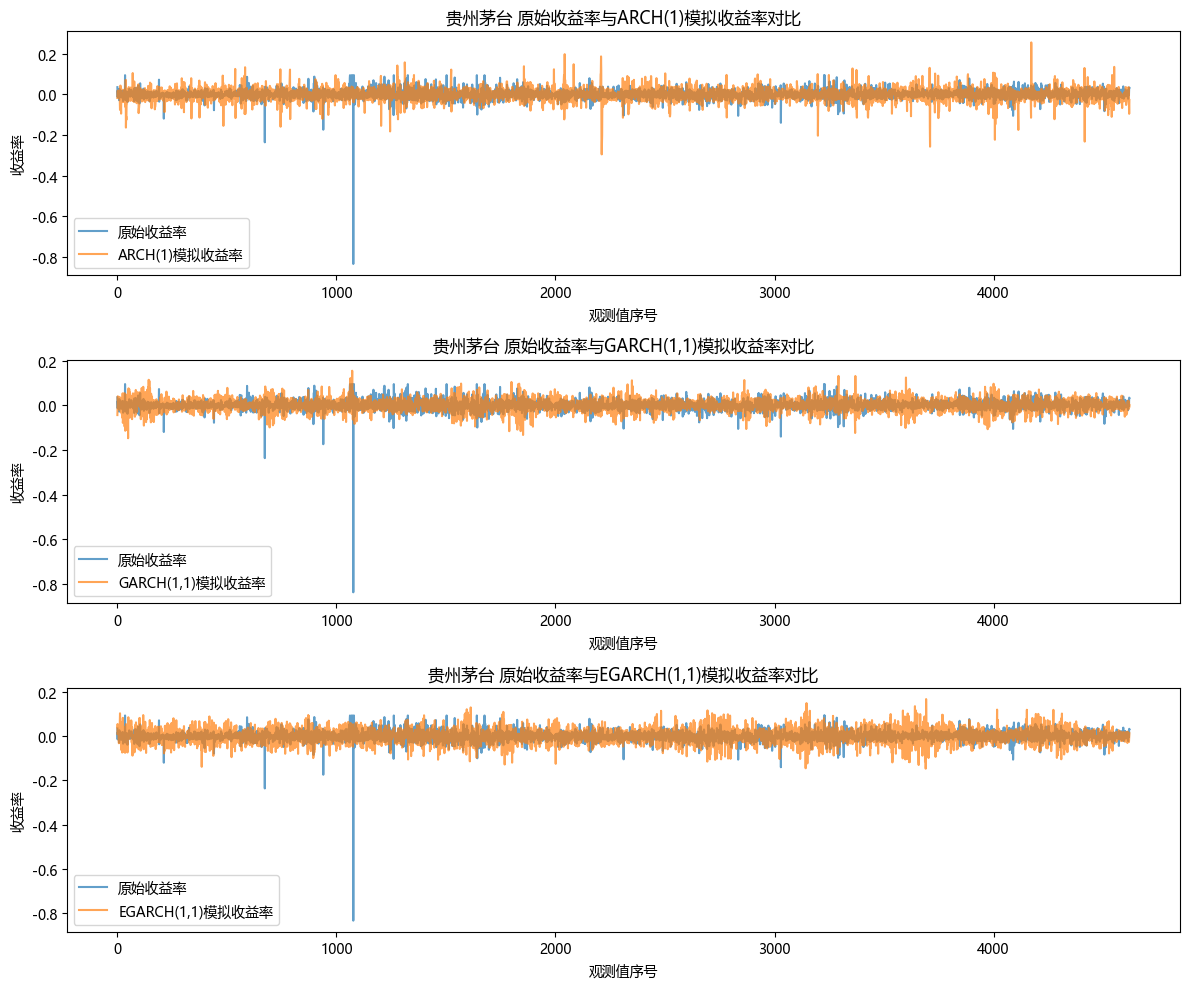

In [13]:
stock1_sim_arch1, stock1_sim_garch11, stock1_sim_egarch11 = simulate_and_compare(
    stock1_returns['returns'], stock1_arch1, stock1_garch11, stock1_egarch11, '贵州茅台')

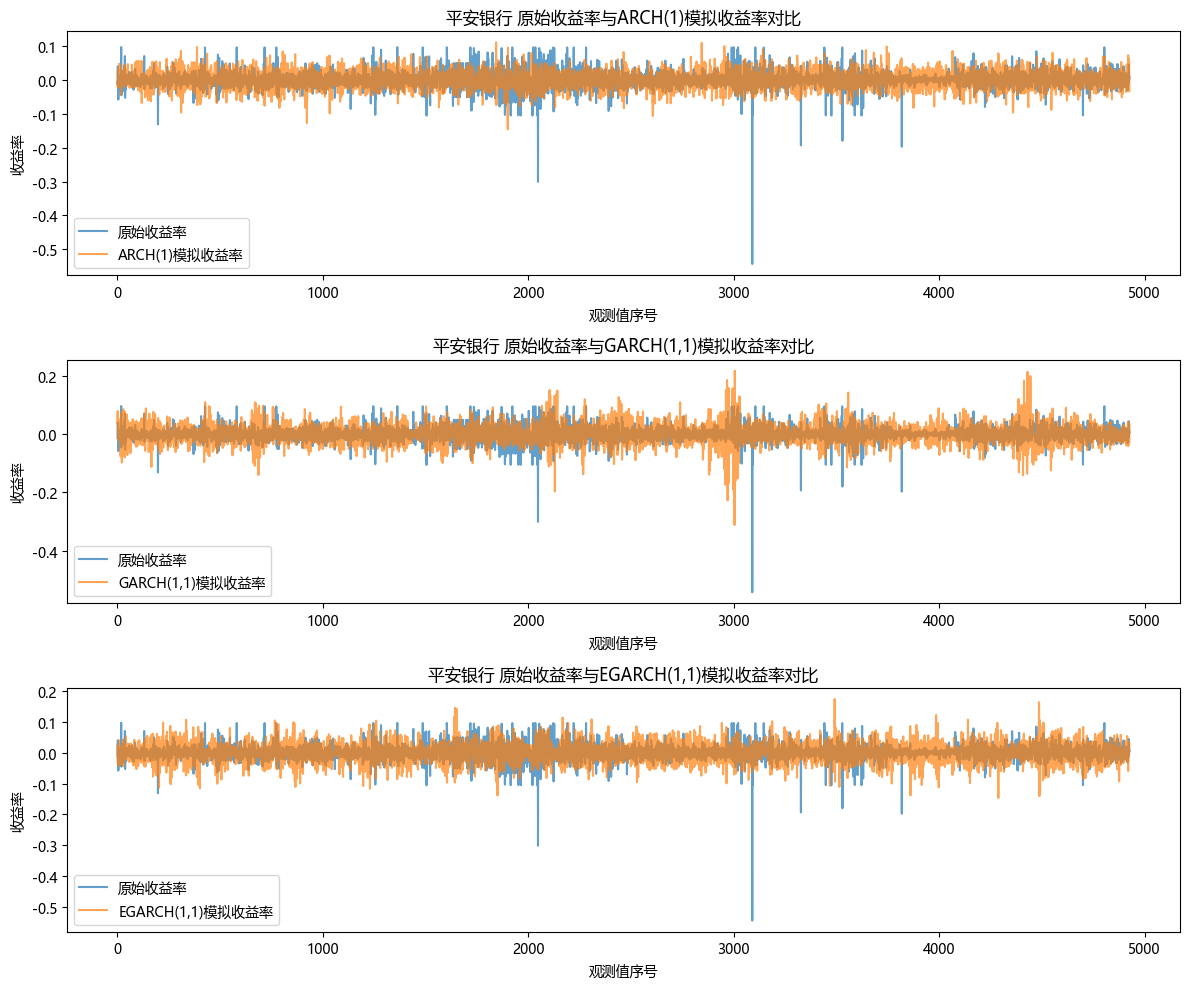

In [14]:
stock2_sim_arch1, stock2_sim_garch11, stock2_sim_egarch11 = simulate_and_compare(
    stock2_returns['returns'], stock2_arch1, stock2_garch11, stock2_egarch11, '平安银行')

# 实验结论

## 一、数据描述性统计分析

从描述性统计结果来看，上证指数、深证成指、贵州茅台和平安银行的收益率数据表现出以下特征：

1. **均值特征**：各收益率序列的均值都接近于0，符合金融时间序列的一般特征。

2. **波动性特征**：
   - 上证指数和深证成指的标准差分别为0.015和0.017，相对较低
   - 个股（贵州茅台和平安银行）的标准差分别为0.025和0.026，波动性明显高于市场指数

3. **分布特征**：
   - 所有样本数据均表现出显著的负偏度，意味着大幅下跌的概率高于大幅上涨
   - 峰度值都远大于正态分布的3，表明收益率分布呈现典型的"尖峰厚尾"特征
   - 贵州茅台和平安银行的峰度值特别高（分别为293和45），说明极端收益率的出现频率远高于正态分布预测

4. **自相关性**：
   - 收益率序列的一阶自相关系数较小，表明收益率本身的自相关性不强
   - 收益率绝对值的自相关系数明显高于收益率本身，如上证指数收益率绝对值的自相关系数达0.179，这是波动率聚集现象的典型特征

## 二、ARCH效应检验

ARCH效应检验结果表明：

1. **市场指数**：上证指数和深证成指均存在显著的ARCH效应，LM统计量的p值接近于0，强烈拒绝了"不存在ARCH效应"的原假设。这表明市场指数收益率的波动率具有明显的时变特征和聚集性。

2. **个股**：贵州茅台和平安银行的ARCH效应检验未能拒绝原假设，即统计上看，这两只个股的收益率序列不存在显著的ARCH效应。这与市场指数的特征形成明显对比，可能与个股特有的微观因素有关。

## 三、ARCH(1)和GARCH(1,1)模型估计

1. **ARCH(1)模型**：
   - 对于上证指数和深证成指，ARCH(1)模型的估计结果显示alpha(1)参数显著为正，分别为0.266和0.205，表明前一期的波动对当期波动有正向影响
   - 但ARCH(1)模型的标准化残差仍存在ARCH效应，说明一阶ARCH模型不足以完全捕捉波动聚集特征

2. **GARCH(1,1)模型**：
   - 对于所有样本，GARCH(1,1)模型中的alpha(1)和beta(1)参数均显著为正，且满足稳定性条件(alpha+beta<1)
   - 上证指数的alpha(1)=0.080，beta(1)=0.915，表明波动率具有很强的持续性
   - 深证成指的结果类似，alpha(1)=0.072，beta(1)=0.917
   - 贵州茅台的alpha(1)=0.123，beta(1)=0.854
   - 平安银行的alpha(1)=0.161，beta(1)=0.814

3. **模型评价**：
   - GARCH(1,1)模型的标准化残差的ARCH效应检验结果表明，所有样本数据在经过GARCH(1,1)模型拟合后，其标准化残差不再存在ARCH效应
   - 这说明GARCH(1,1)模型能够有效捕捉中国股市波动率的聚集特征

## 四、EGARCH(1,1)模型估计

1. **参数估计**：
   - 所有样本的EGARCH(1,1)模型中，alpha(1)参数均显著为正，表明波动率对冲击具有敏感性
   - beta(1)参数都接近于1（上证指数为0.986，深证成指为0.985，贵州茅台为0.979，平安银行为0.942），表明波动率具有很强的持续性

2. **杠杆效应检验**：
   - 深证成指的gamma(1)参数为-0.0232，p值为0.015，表明存在显著的负向杠杆效应，即负面冲击对波动率的影响大于正面冲击
   - 上证指数的gamma(1)参数为-0.0215，p值为0.057，接近显著水平，表明可能存在弱杠杆效应
   - 贵州茅台的gamma(1)为0.069，且显著为正，这与传统的杠杆效应理论相反，可能反映了该股票的特殊性质
   - 平安银行的gamma(1)不显著，表明不存在明显的杠杆效应

3. **标准化残差检验**：
   - 所有样本的EGARCH(1,1)模型标准化残差均不存在ARCH效应，表明该模型能够充分捕捉条件异方差特性

## 五、模型模拟与对比

从提供的模拟对比图可以看出：

1. **ARCH(1)模型**：
   - 能够部分捕捉波动聚集特征，但模拟收益率的波动幅度普遍小于实际收益率
   - 无法很好地模拟极端收益率事件

2. **GARCH(1,1)模型**：
   - 相比ARCH(1)模型，GARCH(1,1)模型模拟的收益率序列更接近原始数据的波动特征
   - 对波动持续性的刻画更为准确，但对极端事件的模拟仍有不足

3. **EGARCH(1,1)模型**：
   - 模拟效果整体上最佳，尤其是对于存在杠杆效应的深证成指
   - 能够更好地捕捉波动的不对称性，模拟序列展现出更丰富的动态特征

## 总结与启示

1. 中国股市收益率序列表现出典型的金融时间序列特征：均值接近于0、分布呈现尖峰厚尾、波动具有聚集性。

2. 市场指数（上证指数和深证成指）存在显著的ARCH效应，而个股（贵州茅台和平安银行）的ARCH效应不显著，这表明市场整体波动与个股波动可能受到不同因素的影响。

3. GARCH(1,1)模型能够有效捕捉中国股市收益率的条件异方差特性，优于简单的ARCH(1)模型。所有样本的GARCH参数都表明波动率具有很强的持续性（beta接近1）。

4. 深证成指存在显著的杠杆效应，上证指数也表现出弱杠杆效应，而贵州茅台展现出与传统理论相反的反向杠杆效应，这反映了不同市场主体对正负面信息的不同反应机制。

5. EGARCH(1,1)模型在考虑了波动不对称性后，对中国股市波动特征的刻画最为准确，尤其适合具有杠杆效应的市场指数。

这些发现对投资者和监管者都具有重要意义：投资者可以利用这些模型更准确地估计市场风险，优化投资组合；监管者则可以通过波动率模型更好地理解市场波动的传导机制，制定更有针对性的监管政策。